In [10]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras import layers, ops, Model, random
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense
from keras.models import Sequential
from keras import regularizers

In [11]:
# Download Galaxy10 DECaLS (HDF5)
! rm ./Galaxy10_DECals_64.h5
! wget https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
data_path = "./Galaxy10_DECals_64.h5"

print("Downloaded to:", data_path)

--2025-12-13 21:38:42--  https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.53.35, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159140118 (152M) [application/octet-stream]
Saving to: ‘Galaxy10_DECals_64.h5’

Galaxy10_DECals_64. 100%[===================>] 151.77M  17.3MB/s    in 9.9s    

2025-12-13 21:38:54 (15.4 MB/s) - ‘Galaxy10_DECals_64.h5’ saved [159140118/159140118]

Downloaded to: ./Galaxy10_DECals_64.h5


SETUP

In [12]:
# Load images and labels using h5py
with h5py.File(data_path, "r") as f:
    images = np.array(f["images"])   # shape (17736, 256, 256, 3)
    labels = np.array(f["ans"])      # shape (17736,)

# Normalize pixels in [0,1]
images = images/255

print("Images shape:", images.shape)

Images shape: (17736, 64, 64, 3)


In [13]:
x_train, x_temp, y_train, y_temp = train_test_split(
    images,
    labels,
    test_size=0.5,
    random_state=42
)

# Second split: temp into val (25%) and test (25%) of full standard data
x_val, x_test, y_val, y_test = train_test_split(
    x_temp,
    y_temp,
    test_size=0.5,
    random_state=42
)

print("Train standard:", x_train.shape, y_train.shape)
print("Val standard:  ", x_val.shape, y_val.shape)
print("Test standard: ", x_test.shape, y_test.shape)
del x_temp, y_temp

Train standard: (8868, 64, 64, 3) (8868,)
Val standard:   (4434, 64, 64, 3) (4434,)
Test standard:  (4434, 64, 64, 3) (4434,)


GAN

In [14]:
# ==========
# Generator
# ==========
def build_generator(latent_dim):
    noise = layers.Input(shape=(latent_dim,))

    x = layers.Dense(4 * 4 * 256, activation="relu")(noise)
    x = layers.Reshape((4, 4, 256))(x)

    x = layers.Conv2DTranspose(256, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Output: 64x64x3, values in [0,1] using sigmoid
    img = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

    model = Model(noise, img, name="generator")
    model.summary()
    return model

In [15]:
def build_critic(img_shape):
    img_input = layers.Input(shape=img_shape)

    x = Conv2D(32, (3, 3), padding='same')(img_input)
    x = ReLU()(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = ReLU()(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)

    x = Conv2D(128, (3, 3), padding='same',
               kernel_regularizer=regularizers.l2(1e-4))(x)
    x = ReLU()(x)
    x = Conv2D(128, (3, 3), padding='same',
               kernel_regularizer=regularizers.l2(1e-4))(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)

    # Critic output: NO sigmoid
    score = Dense(1)(x)

    model = Model(img_input, score, name="critic")
    model.summary()
    return model

In [25]:
# ==========
# Hyperparameters
# ==========
latent_dim = 100
img_shape = x_train.shape[1:]
batch_size = 64
epochs = 15

In [17]:
generator = build_generator(latent_dim)
critic = build_critic(img_shape)

critic_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.0, beta_2=0.9
)
generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.0, beta_2=0.9
)

dummy_noise = tf.random.normal([1, latent_dim])
dummy_img = generator(dummy_noise)
dummy_score = critic(dummy_img)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │       413,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,393,859 (5.32 MB)

 Trainable params: 1,392,899 (5.31 MB)

 Non-trainable params: 960 (3.75 KB)

Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,649 (1.16 MB)

 Trainable params: 303,649 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
def gradient_penalty(critic, real_images, fake_images):
    batch_size = tf.shape(real_images)[0]
    epsilon = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)

    interpolated = epsilon * real_images + (1 - epsilon) * fake_images

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        interpolated_score = critic(interpolated, training=True)

    grads = gp_tape.gradient(interpolated_score, interpolated)
    grads_norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))

    return tf.reduce_mean((grads_norm - 1.0) ** 2)

In [19]:
@tf.function
def train_critic(real_images):
    noise = tf.random.normal([batch_size, latent_dim])
    fake_images = generator(noise, training=True)

    with tf.GradientTape() as tape:
        real_scores = critic(real_images, training=True)
        fake_scores = critic(fake_images, training=True)

        # Wasserstein critic loss
        loss = tf.reduce_mean(fake_scores) - tf.reduce_mean(real_scores)

        # Gradient penalty
        gp = gradient_penalty(critic, real_images, fake_images)
        loss += lambda_gp * gp

    gradients = tape.gradient(loss, critic.trainable_variables)
    critic_optimizer.apply_gradients(
        zip(gradients, critic.trainable_variables)
    )

    return loss

In [20]:
@tf.function
def train_generator():
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as tape:
        fake_images = generator(noise, training=True)
        fake_scores = critic(fake_images, training=True)
        loss = -tf.reduce_mean(fake_scores)

    gradients = tape.gradient(loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(
        zip(gradients, generator.trainable_variables)
    )

    return loss

In [26]:

# ========== # Training loop # ========== # Use your x_train from the split you did earlier
x_real = x_train.astype("float32")   # already in [0,1] and shape (28,28,1)
lambda_gp = 10 # gradient penalty coefficient
half_batch = batch_size // 2
steps_per_epoch = max(1, x_real.shape[0] // batch_size)

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    prog_bar = tf.keras.utils.Progbar(steps_per_epoch)

    for step in range(steps_per_epoch):

        # ---- Train Critic ----
        idx = np.random.randint(0, x_real.shape[0], batch_size)
        real_imgs = x_real[idx]
        loss_c = train_critic(real_imgs)  # train_critic as defined previously

        # ---- Train Generator ----
        loss_g = train_generator()  # train_generator as defined previously

        prog_bar.update(step + 1, [("critic_loss", loss_c), ("generator_loss", loss_g)])



Epoch 1/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 31s 202ms/step - critic_loss: -0.2223 - generator_loss: 7.3683

Epoch 2/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 27s 200ms/step - critic_loss: 0.0780 - generator_loss: 8.0364

Epoch 3/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 27s 198ms/step - critic_loss: 0.1159 - generator_loss: 6.5811

Epoch 4/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 27s 198ms/step - critic_loss: 0.0486 - generator_loss: 7.4684

Epoch 5/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 27s 198ms/step - critic_loss: 0.0512 - generator_loss: 6.8526

Epoch 6/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 27s 198ms/step - critic_loss: 0.1603 - generator_loss: 9.0196

Epoch 7/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 27s 199ms/step - critic_loss: 0.0987 - generator_loss: 7.8569

Epoch 8/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 27s 199ms/step - critic_loss: 0.0987 - generator_loss: 7.4397

Epoch 9/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 27s 198ms/step - critic_loss: 0.1426 - generator_loss: 6.3888

Epoch 10/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 27s 198ms/step - critic_loss: 

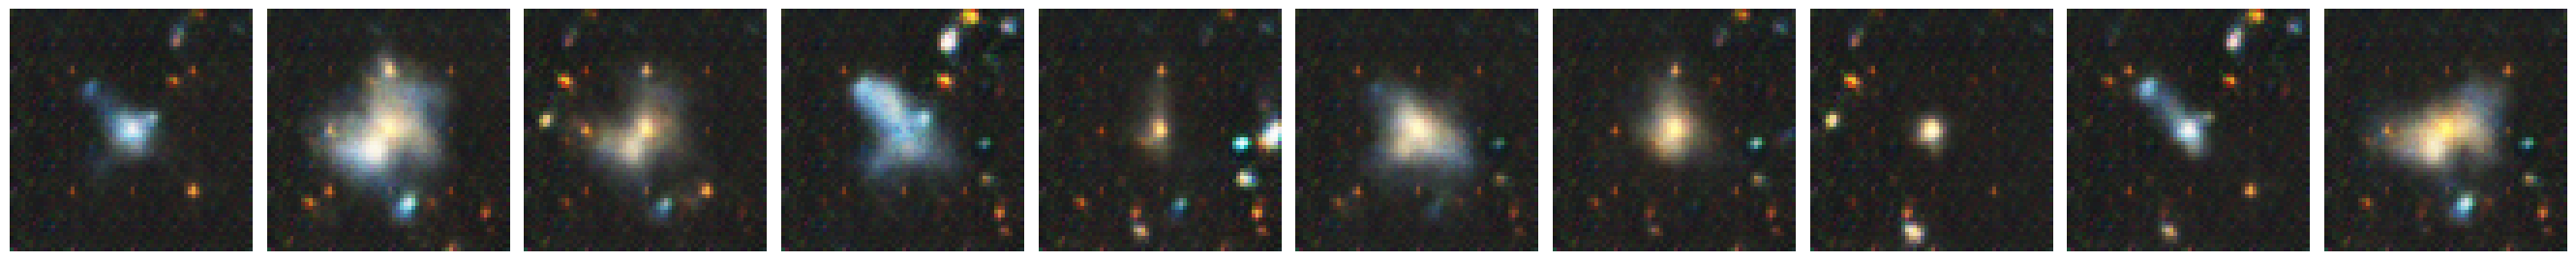

In [32]:
def show_generated_images(generator, n=25):
    noise = np.random.normal(0, 1, (n, latent_dim))
    gen_imgs = generator.predict(noise, verbose=0)

    plt.figure(figsize=(40,40))
    for i in range(n):
        plt.subplot(15, 15, i+1)
        plt.imshow(gen_imgs[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()
show_generated_images(generator, n=10)